In [1]:
import xarray as xr
import sklearn

import numpy as np
import pandas as pd
from pathlib import Path

import os, sys
import glob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
#import seaborn as sns
#sns.set_style('ticks')

from scipy import stats
from scipy.signal import detrend
from scipy.stats import percentileofscore

from datetime import datetime, timedelta

# Load the non tidal residuals, era5 anomalies, PDO indices, and ENSO indices to combine in one csv for regression testing

Does it make sense to calculate an anomaly for PDO and ENSO indices?

In [2]:
#looks like these files are on expanse /expanse/lustre/scratch/jisrael/temp_project/Savio_scratch_back_up/time_varying_data/sl_regression/
enso_raw=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/sl_regression/ERSST_EN3.4_index.csv",skiprows=1)
pdo_raw=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/sl_regression/ERSST_PDO_index.csv",skiprows=1)
enso_raw.drop(enso_raw.tail(3).index,
        inplace = True)
#for enso also drop the last 3 rows
pdo_raw

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1854,0.11,-0.24,-0.40,-0.44,-0.54,-0.30,-0.10,-1.24,-1.00,-2.23,-1.68,-1.76
1,1855,-0.20,-0.39,-0.24,-0.58,-1.34,-1.88,-1.13,-0.48,-0.76,-0.63,-0.41,-0.88
2,1856,-0.39,0.47,0.42,-0.96,-1.26,-2.15,-0.69,0.63,0.58,0.59,0.23,0.04
3,1857,-0.52,-1.67,-1.05,-0.81,-0.65,1.03,1.17,0.81,0.84,0.70,0.38,-0.55
4,1858,-0.96,-1.53,-1.76,-0.82,0.49,2.19,1.05,0.67,1.38,2.35,0.46,-1.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,2021,-0.61,-1.09,-1.67,-1.84,-2.04,-1.82,-2.00,-0.95,-1.96,-3.13,-2.75,-2.71
168,2022,-2.40,-1.91,-1.67,-2.09,-2.24,-1.32,-2.64,-2.38,-2.29,-1.81,-2.41,-2.21
169,2023,-1.24,-1.65,-2.45,-3.07,-2.42,-2.53,-2.52,-2.47,-2.99,-2.23,-1.79,-1.66
170,2024,-1.57,-1.33,-1.52,-2.11,-2.98,-3.15,-3.00,-2.91,-3.56,-3.80,-3.13,-2.03


In [3]:
enso_raw

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1949,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1950,24.55,25.06,25.87,26.28,26.18,26.46,26.29,25.88,25.74,25.69,25.47,25.29
2,1951,25.24,25.71,26.9,27.58,27.92,27.73,27.60,27.02,27.23,27.20,27.25,26.91
3,1952,26.67,26.74,27.17,27.8,27.79,27.18,26.53,26.30,26.36,26.26,25.92,26.21
4,1953,26.74,27,27.57,28.04,28.28,28.12,27.43,26.94,27.01,26.87,26.88,27.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2021,25.55,25.75,26.48,27.1,27.47,27.45,26.90,26.32,26.17,25.77,25.76,25.54
73,2022,25.6,25.86,26.31,26.7,26.82,26.98,26.60,25.88,25.65,25.73,25.80,25.75
74,2023,25.83,26.29,27.17,27.96,28.39,28.57,28.32,28.20,28.32,28.44,28.72,28.62
75,2024,28.35,28.27,28.41,28.59,28.16,27.9,27.34,26.73,26.45,26.44,26.45,26.00


reformat to be a time series

In [4]:
pdo_raw.index

RangeIndex(start=0, stop=172, step=1)

In [5]:
len(pdo_raw)

172

In [6]:
np.array(pdo_raw.loc[[0]][['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']])

array([[ 0.11, -0.24, -0.4 , -0.44, -0.54, -0.3 , -0.1 , -1.24, -1.  ,
        -2.23, -1.68, -1.76]])

In [7]:
test=np.array(pdo_raw.loc[[0]][['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']])

In [8]:
start=np.array([])
# start=np.empty(len(pdo_raw)*12)

In [9]:
test2=np.append(test,test)
print(test2)
print(test2.shape)

[ 0.11 -0.24 -0.4  -0.44 -0.54 -0.3  -0.1  -1.24 -1.   -2.23 -1.68 -1.76
  0.11 -0.24 -0.4  -0.44 -0.54 -0.3  -0.1  -1.24 -1.   -2.23 -1.68 -1.76]
(24,)


In [10]:
#reorder the above to be one long vector
pdo_v=np.array([])
enso_v=np.array([])
for i in pdo_raw.index:
    pdo_v=np.append(pdo_v, np.array(pdo_raw.loc[[i]][['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
   
print(pdo_v.shape)

for j in enso_raw.index:
     enso_v=np.append(enso_v, np.array(enso_raw.loc[[j]][['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
enso_v=enso_v.astype(float)
print(enso_v.shape)

(2064,)
(924,)


In [11]:
#replace the -99.99 values with NaN
bad = np.absolute(enso_v) == 99.99
enso_v[bad] = np.nan
bad = np.absolute(pdo_v) == 99.99
pdo_v[bad] = np.nan
#print(enso_v)

In [12]:
# pdo_v.dropna

In [13]:
str(int(pdo_raw.tail(1).Year.values)+1)

/tmp/ipykernel_530126/2043721629.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  str(int(pdo_raw.tail(1).Year.values)+1)


'2026'

In [14]:
#turn this into a dataframe using a fake time vector
pdo_t=np.arange(str(int(pdo_raw.loc[[0]].Year.values)), str(int(pdo_raw.tail(1).Year.values)+1), dtype='datetime64[M]') #add one to the last year bc not inclusive
pdo_t

/tmp/ipykernel_530126/3249427760.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pdo_t=np.arange(str(int(pdo_raw.loc[[0]].Year.values)), str(int(pdo_raw.tail(1).Year.values)+1), dtype='datetime64[M]') #add one to the last year bc not inclusive


array(['1854-01', '1854-02', '1854-03', ..., '2025-10', '2025-11',
       '2025-12'], dtype='datetime64[M]')

In [15]:
enso_t=np.arange(str(int(enso_raw.loc[[0]].Year.values)), str(int(enso_raw.tail(1).Year.values)+1), dtype='datetime64[M]') #add one to the last year bc not inclusive
#enso_t

/tmp/ipykernel_530126/1836222809.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  enso_t=np.arange(str(int(enso_raw.loc[[0]].Year.values)), str(int(enso_raw.tail(1).Year.values)+1), dtype='datetime64[M]') #add one to the last year bc not inclusive


Convert to a dataframe and then drop the na which is going to cause issues for detrending (should be okay because they are at the beginning and end) 

In [16]:
pdo_df=pd.DataFrame(index=pdo_t,data=pdo_v,columns=['PDO']).dropna()
#convert to float before writing to data frame x.astype(float)
enso_df=pd.DataFrame(index=enso_t,data=enso_v,columns=['EN3.4']).dropna()

In [17]:
type(enso_v[1])

numpy.float64

In [18]:
enso_df['EN3.4']

1950-01-01    24.55
1950-02-01    25.06
1950-03-01    25.87
1950-04-01    26.28
1950-05-01    26.18
              ...  
2024-11-01    26.45
2024-12-01    26.00
2025-01-01    25.81
2025-02-01    26.32
2025-03-01    27.28
Name: EN3.4, Length: 903, dtype: float64

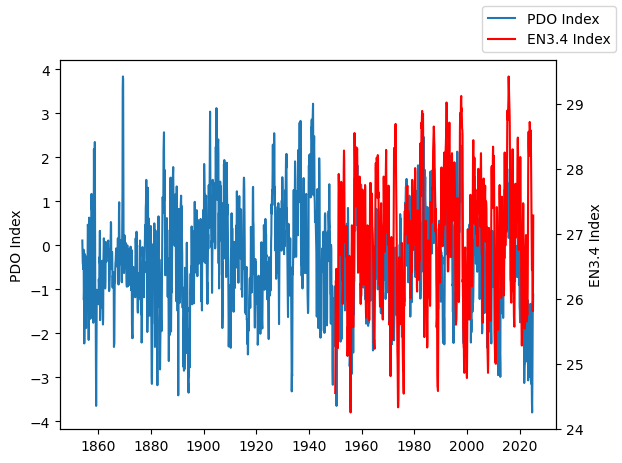

In [19]:
fig, ax = plt.subplots(sharex=True)

ax.plot(pdo_df.PDO,label='PDO Index')
ax.set_ylabel('PDO Index')
ax2=ax.twinx()
ax2.plot(enso_df['EN3.4'], label='EN3.4 Index',color='r')
ax2.set_ylabel('EN3.4 Index')

#ax.set_xlim(datetime(1995,1,1),datetime(2021,1,1))

fig.legend()

In [20]:
pdo_df

,PDO
1854-01-01,0.11
1854-02-01,-0.24
1854-03-01,-0.40
1854-04-01,-0.44
1854-05-01,-0.54
...,...
2024-11-01,-3.13
2024-12-01,-2.03
2025-01-01,-1.28
2025-02-01,-1.41


In [21]:
pdo_df.dropna()

,PDO
1854-01-01,0.11
1854-02-01,-0.24
1854-03-01,-0.40
1854-04-01,-0.44
1854-05-01,-0.54
...,...
2024-11-01,-3.13
2024-12-01,-2.03
2025-01-01,-1.28
2025-02-01,-1.41


In [22]:
#Should probably detrend both datasets, need to drop the nans first
pdo_df['PDO_d']=detrend(pdo_df['PDO'],type='linear')
enso_df['EN3.4_d']=detrend(enso_df['EN3.4'],type='linear')
print(pdo_df['PDO_d'].mean())
print(enso_df['EN3.4_d'].mean())

-1.7288144422386866e-17
-1.6642280023616964e-14


In [23]:
#calculate the anomaly
pdo_df['PDO_a']=pdo_df['PDO_d']-pdo_df['PDO_d'].mean()
enso_df['EN3.4_a']=enso_df['EN3.4_d']-enso_df['EN3.4_d'].mean()

In [24]:
enso_df['EN3.4_a']

1950-01-01   -2.110991
1950-02-01   -1.601526
1950-03-01   -0.792062
1950-04-01   -0.382598
1950-05-01   -0.483133
                ...   
2024-11-01   -0.692027
2024-12-01   -1.142563
2025-01-01   -1.333099
2025-02-01   -0.823634
2025-03-01    0.135830
Name: EN3.4_a, Length: 903, dtype: float64

#resample to be hourly but use the value for the month for all the days in that month

In [25]:
pdo_hourly=pdo_df["PDO_a"].resample('1h').ffill() #forward fill the value for the whole month
enso_hourly=enso_df['EN3.4_a'].resample('1h').ffill() 

Load the ERA5 data

In [26]:
era5_m=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/era5/monterey/monterey_anomalies_36.5_122.0.csv",parse_dates=["valid_time"]).set_index(["valid_time"])
era5_pr=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/era5/point_reyes/point_reyes_anomalies_38.0_123.25.csv",parse_dates=["valid_time"]).set_index(["valid_time"])
era5_m

,u10_stress_a,v10_stress_a,msl_a,sst_a
valid_time,,,,
1970-01-01 00:00:00,-3.070642,-1.170650,669.512711,-0.521550
1970-01-01 01:00:00,-2.848234,-3.210390,698.327676,-0.521550
1970-01-01 02:00:00,-3.586008,-1.297828,665.262641,-0.521550
1970-01-01 03:00:00,-4.279772,-1.620550,678.762606,-0.521551
1970-01-01 04:00:00,-6.040990,-3.819356,661.142571,-0.521551
...,...,...,...,...
2025-01-01 19:00:00,-8.844623,-0.405153,612.918883,-0.373825
2025-01-01 20:00:00,-3.020198,-11.571639,554.603848,-0.373825
2025-01-01 21:00:00,0.439085,-20.861576,500.668813,-0.373825


Load the non tidal residuals

In [27]:
tidal_m=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/utide.residuals.montereybay.1996.2021.csv",parse_dates=["Date Time"]).set_index(["Date Time"])
tidal_pr=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/utide.residuals.pointreyes.1996.2021.csv",parse_dates=["Date Time"]).set_index(["Date Time"])
tidal_m

,Date Time.1,Water Level,Sigma,O or I (for verified),F,R,L,Quality,flag,elev,interp,detrend,anomaly,Residual,Predicted Tide
Date Time,,,,,,,,,,,,,,,
1995-12-31 16:00:00,1995-12-31 16:00:00,0.389,0.107,0,0,0,0,v,0.0,0.389,0.389,-0.490776,-0.490776,-0.041856,-0.448920
1995-12-31 16:06:00,1995-12-31 16:06:00,0.381,0.130,0,0,0,0,v,0.0,0.381,0.381,-0.498776,-0.498776,-0.072251,-0.426526
1995-12-31 16:12:00,1995-12-31 16:12:00,0.471,0.154,0,0,0,0,v,0.0,0.471,0.471,-0.408776,-0.408776,-0.004962,-0.403814
1995-12-31 16:18:00,1995-12-31 16:18:00,0.494,0.113,0,0,0,0,v,0.0,0.494,0.494,-0.385776,-0.385776,-0.004932,-0.380844
1995-12-31 16:24:00,1995-12-31 16:24:00,0.474,0.088,0,0,0,0,v,0.0,0.474,0.474,-0.405776,-0.405776,-0.048102,-0.357674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 23:30:00,2021-10-01 23:30:00,0.423,0.076,0,0,0,0,v,0.0,0.423,0.423,-0.538693,-0.538693,-0.008114,-0.530580
2021-10-01 23:36:00,2021-10-01 23:36:00,0.378,0.122,0,0,0,0,v,0.0,0.378,0.378,-0.583693,-0.583693,-0.028816,-0.554877
2021-10-01 23:42:00,2021-10-01 23:42:00,0.375,0.083,0,0,0,0,v,0.0,0.375,0.375,-0.586693,-0.586693,-0.008441,-0.578252


Resample the non tidal residuals to be hourly (to match era5)

In [28]:
# ntr_m.set_index(["Date Time"])["Residual"].resample('1h').mean()

In [29]:
ntr_m_h=tidal_m["Residual"].resample('1h').mean()
ntr_pr_h=tidal_pr["Residual"].resample('1h').mean()

In [30]:
#rename the oscillation dataframes and era5 to have index "Date Time"
era5_m.index.rename("Date Time")
era5_pr.index.rename("Date Time")
pdo_hourly.index.rename("Date Time")
enso_hourly.index.rename("Date Time")
era5_m

,u10_stress_a,v10_stress_a,msl_a,sst_a
valid_time,,,,
1970-01-01 00:00:00,-3.070642,-1.170650,669.512711,-0.521550
1970-01-01 01:00:00,-2.848234,-3.210390,698.327676,-0.521550
1970-01-01 02:00:00,-3.586008,-1.297828,665.262641,-0.521550
1970-01-01 03:00:00,-4.279772,-1.620550,678.762606,-0.521551
1970-01-01 04:00:00,-6.040990,-3.819356,661.142571,-0.521551
...,...,...,...,...
2025-01-01 19:00:00,-8.844623,-0.405153,612.918883,-0.373825
2025-01-01 20:00:00,-3.020198,-11.571639,554.603848,-0.373825
2025-01-01 21:00:00,0.439085,-20.861576,500.668813,-0.373825


In [31]:
era5_m[["u10_stress_a","v10_stress_a","msl_a","sst_a"]]

,u10_stress_a,v10_stress_a,msl_a,sst_a
valid_time,,,,
1970-01-01 00:00:00,-3.070642,-1.170650,669.512711,-0.521550
1970-01-01 01:00:00,-2.848234,-3.210390,698.327676,-0.521550
1970-01-01 02:00:00,-3.586008,-1.297828,665.262641,-0.521550
1970-01-01 03:00:00,-4.279772,-1.620550,678.762606,-0.521551
1970-01-01 04:00:00,-6.040990,-3.819356,661.142571,-0.521551
...,...,...,...,...
2025-01-01 19:00:00,-8.844623,-0.405153,612.918883,-0.373825
2025-01-01 20:00:00,-3.020198,-11.571639,554.603848,-0.373825
2025-01-01 21:00:00,0.439085,-20.861576,500.668813,-0.373825


In [32]:
## era5_m.merge(pdo_hourly, how='left', on='Date Time')
#pd.concat([era5_m[["u10_stress_a","v10_stress_a","msl_a","sst_a"], pdo_hourly["PDO"], enso_hourly["EN3.4"], ntr_m_h["Residual"]], axis=1)

df_m=pd.concat([era5_m, pdo_hourly, enso_hourly, ntr_m_h], axis=1)#.dropna()
df_pr=pd.concat([era5_pr, pdo_hourly, enso_hourly, ntr_pr_h], axis=1)#.dropna()
df_m

,u10_stress_a,v10_stress_a,msl_a,sst_a,PDO_a,EN3.4_a,Residual
1854-01-01 00:00:00,NaN,NaN,NaN,NaN,0.364081,NaN,NaN
1854-01-01 01:00:00,NaN,NaN,NaN,NaN,0.364081,NaN,NaN
1854-01-01 02:00:00,NaN,NaN,NaN,NaN,0.364081,NaN,NaN
1854-01-01 03:00:00,NaN,NaN,NaN,NaN,0.364081,NaN,NaN
1854-01-01 04:00:00,NaN,NaN,NaN,NaN,0.364081,NaN,NaN
...,...,...,...,...,...,...,...
2025-02-28 20:00:00,NaN,NaN,NaN,NaN,-0.983708,-0.823634,NaN
2025-02-28 21:00:00,NaN,NaN,NaN,NaN,-0.983708,-0.823634,NaN
2025-02-28 22:00:00,NaN,NaN,NaN,NaN,-0.983708,-0.823634,NaN
2025-02-28 23:00:00,NaN,NaN,NaN,NaN,-0.983708,-0.823634,NaN


Rename the time index since it is currently empty

In [39]:
df_m.keys()

Index(['u10_stress_a', 'v10_stress_a', 'msl_a', 'sst_a', 'PDO_a', 'EN3.4_a',
       'Residual'],
      dtype='object')

In [41]:
df_m.rename_axis("time")

,u10_stress_a,v10_stress_a,msl_a,sst_a,PDO_a,EN3.4_a,Residual
1854-01-01 00:00:00,NaN,NaN,NaN,NaN,0.364081,NaN,NaN
1854-01-01 01:00:00,NaN,NaN,NaN,NaN,0.364081,NaN,NaN
1854-01-01 02:00:00,NaN,NaN,NaN,NaN,0.364081,NaN,NaN
1854-01-01 03:00:00,NaN,NaN,NaN,NaN,0.364081,NaN,NaN
1854-01-01 04:00:00,NaN,NaN,NaN,NaN,0.364081,NaN,NaN
...,...,...,...,...,...,...,...
2025-02-28 20:00:00,NaN,NaN,NaN,NaN,-0.983708,-0.823634,NaN
2025-02-28 21:00:00,NaN,NaN,NaN,NaN,-0.983708,-0.823634,NaN
2025-02-28 22:00:00,NaN,NaN,NaN,NaN,-0.983708,-0.823634,NaN
2025-02-28 23:00:00,NaN,NaN,NaN,NaN,-0.983708,-0.823634,NaN


Trim the array to start and end without nans

In [42]:
df_m_trim=df_m.loc[df_m["Residual"].first_valid_index():df_m["Residual"].last_valid_index()].rename_axis("time")
df_pr_trim=df_pr.loc[df_pr["Residual"].first_valid_index():df_pr["Residual"].last_valid_index()].rename_axis("time")

Also remove the dates Sam attributed to tsunami 
(1964: Mar28 to Apr1
2010: Feb27 to Mar/2
2011: Mar11 to Mar14)

In [43]:
ts1=pd.date_range(start='2/27/2010', end='3/2/2010', freq='H')
ts2=pd.date_range(start='3/11/2011', end='3/14/2011', freq='H')
tstotal=ts1.union(ts2)
tstotal

/tmp/ipykernel_530126/1211616275.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts1=pd.date_range(start='2/27/2010', end='3/2/2010', freq='H')
/tmp/ipykernel_530126/1211616275.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts2=pd.date_range(start='3/11/2011', end='3/14/2011', freq='H')


DatetimeIndex(['2010-02-27 00:00:00', '2010-02-27 01:00:00',
               '2010-02-27 02:00:00', '2010-02-27 03:00:00',
               '2010-02-27 04:00:00', '2010-02-27 05:00:00',
               '2010-02-27 06:00:00', '2010-02-27 07:00:00',
               '2010-02-27 08:00:00', '2010-02-27 09:00:00',
               ...
               '2011-03-13 15:00:00', '2011-03-13 16:00:00',
               '2011-03-13 17:00:00', '2011-03-13 18:00:00',
               '2011-03-13 19:00:00', '2011-03-13 20:00:00',
               '2011-03-13 21:00:00', '2011-03-13 22:00:00',
               '2011-03-13 23:00:00', '2011-03-14 00:00:00'],
              dtype='datetime64[ns]', length=146, freq=None)

In [35]:
df_m_trim.loc[tstotal]["Residual"]

2010-02-27 00:00:00    0.271700
2010-02-27 01:00:00    0.275853
2010-02-27 02:00:00    0.270447
2010-02-27 03:00:00    0.269606
2010-02-27 04:00:00    0.273812
                         ...   
2011-03-13 20:00:00   -0.134942
2011-03-13 21:00:00   -0.107207
2011-03-13 22:00:00   -0.119815
2011-03-13 23:00:00   -0.127395
2011-03-14 00:00:00   -0.103787
Name: Residual, Length: 146, dtype: float64

In [44]:
df_m_trim.loc[tstotal]["Residual"]=np.nan
df_pr_trim.loc[tstotal]["Residual"]=np.nan

In [45]:
df_m_trim

,u10_stress_a,v10_stress_a,msl_a,sst_a,PDO_a,EN3.4_a,Residual
time,,,,,,,
1995-12-31 16:00:00,8.956125,-43.981939,736.900563,0.659997,0.836933,-1.306148,-0.041708
1995-12-31 17:00:00,5.255560,-33.640463,771.835528,0.659997,0.836933,-1.306148,-0.049622
1995-12-31 18:00:00,4.653470,-29.136661,734.585493,0.659997,0.836933,-1.306148,-0.050717
1995-12-31 19:00:00,7.100264,-24.445409,689.835457,0.659997,0.836933,-1.306148,-0.043857
1995-12-31 20:00:00,15.985210,-32.178663,623.085422,0.659997,0.836933,-1.306148,-0.056559
...,...,...,...,...,...,...,...
2021-10-01 19:00:00,-1.437500,0.301881,-145.706222,1.620365,-2.707063,-1.352207,-0.005646
2021-10-01 20:00:00,1.117509,-0.157175,-153.396257,1.620364,-2.707063,-1.352207,-0.015753
2021-10-01 21:00:00,1.308850,0.070465,-179.146292,1.620364,-2.707063,-1.352207,-0.019239


In [46]:
write_path="/global/scratch/users/jennaisrael/climate_data_processing/sl_regression"
df_m_trim.to_csv(write_path+'/monterey.regression.data.hourly.1996.2020.csv')
df_pr_trim.to_csv(write_path+'/point_reyes.regression.data.hourly.1996.2020.csv')